# Generation and visualization of cycles 
# (paper)

In [1]:
import sys
import os

import scipy.stats as st
import statsmodels.api as sm
import statsmodels.stats.multitest as mt

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%reload_ext autoreload
%autoreload 2
%matplotlib inline

# useful utilities
# -----------------------
sys.path.append("./modules")
import utils
import PDplot
from PDplot import ALPHA, RIPS
# -----------------------


# topological tools
# -----------------------
from ripser import ripser

# Universal distribtion
# -----------------------
RVSTD = st.gumbel_l()
# -----------------------


# Visual fine tuning
# -----------------------
sns.set_theme(style="darkgrid")
FIG_SIZE = (18,5)
sns.set_context("talk")

DPI = 300
FN_TITLE = 30
FN_AXES = 24
FN_LEGEND = 12
COLOR = ['b','r']
# -----------------------


# File location
# -----------------------
ROOT = "./pd_example_files/"

In [2]:
# compute diagram 
# with ripser
# ---------------
def persistenceRipser(P,TH,mxdim=1):
    diagrams = ripser(P,thresh=TH,maxdim=mxdim)['dgms']
    birth_all =  [ [] for _ in range(2) ]
    death_all = [ [] for _ in range(2) ]
    inf_all = [ [] for _ in range(2) ]
    d = 0
    for p in diagrams[0]:
        if (p[1]==np.inf):
            inf_all[d].append(p[0])
        else:
            birth_all[d].append(p[0])
            death_all[d].append(p[1])
    d = 1
    for p in diagrams[1]:
        if (p[1]==np.inf):
            inf_all[d].append(p[0])
        else:
            birth_all[d].append(p[0])
            death_all[d].append(p[1])
    

    return birth_all,death_all,inf_all


def makePDFull(P,th):
    #b,d,i = persistence(P,alpha*th)
    b,d,i = persistenceRipser(P,th)
    p = np.array(d[1])/np.array(b[1])
    ## processing
    return p,i[1],np.array(b[1]),np.array(d[1])

# the weird transformation
def process(P,A=1):
    P=P[P>1]
    P=np.log(np.log(P))
    rvtmp = st.loggamma(c=1,loc=0,scale=1)
    B=RVSTD.mean() - P.mean() * A
    P = A * P + B
    return P

# test significance 
def test(X):
    dist = RVSTD
    tmp = -X
    tmp.sort() 
    X = -tmp 
    pvals = 1 - dist.cdf(X) 
    res, pv, _, _ = mt.multipletests(pvals, alpha=0.05, method='bonferroni')
    return np.sum(res == True),pv,pvals

# Extra Plotting PDs
# --------------------------
# get the slope/offset 
# for significance
def slope(b,d,alpha,A):
    M = len(b)
    P = d/b
    P=P[P>1]
    P=np.log(np.log(P))
    B=RVSTD.mean() - P.mean()*A
    print(f'B: {B}')
    print(f'M: {M}')
    return np.exp((np.exp(-B)*np.log(M/alpha))**(1/A))

# plotting two diagrams
# ----------------------------------
def TwoPDplotLineLog(b,d,b1,d1,label,label1,alpha,ax):
    mx=max(np.max(d),np.max(d1))
    mx = np.log(1.1*mx)
    mn1 = min(np.min(b),np.min(b1))
    mn = np.log(mn1)
    ax.fill([mn,mx,mx],[mn,mn,mx],facecolor='black',edgecolor='gray',alpha=0.1)
  
    ax.scatter(np.log(b),np.log(d),facecolor='black', edgecolor='white',s=200, label=label,alpha=0.799*d/np.max(d)+0.2)
    ax.scatter(np.log(b1),np.log(d1), edgecolor='black',facecolor='white',s=200, label=label1,alpha=0.799*d1/np.max(d1)+0.2)
    
    m = np.log(slope(b,d,alpha,1))
    ax.plot([mn,mx],[mn+m,mx+m],':',c='blue')
    m = np.log(slope(b1,d1,alpha,1))
    ax.plot([mn,mx],[mn+m,mx+m],'--',c='blue')
    
    ax.set_xlabel('Log(Birth)',fontsize=32)
    ax.set_ylabel('Log(Death)',fontsize=32)
    leg=ax.legend(fontsize=FN_AXES, loc='lower right')
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
    #ax.set_title('Persistence Diagram', fontsize=FN_TITLE)
    ax.set(xlim=(mn, mx), ylim=(mn, mx))
    ax.tick_params(axis='x', labelsize=24)
    ax.tick_params(axis='y', labelsize=24)

    ax.set_aspect('equal')

    
# For completeness we have the two generators for points below
# although we do not call them in this notebook

#--------------------
# Create cut annulus
#--------------------
# D = dimension
# N = number of points
# R1 = inner radius
# R2 = outer radius
# A = cut width
#
# If annulus with no cut - set A to 0
def ann_cut(D, N, R1 = 0.5, R2 = 1, A = 0):
    n = 0
    P = np.array([[0.0]*D]*N)
    while n < N:
        p = np.random.uniform(-R2,R2,D)
        if np.linalg.norm(p) > R2 or np.linalg.norm(p) < R1:
            continue
        if ((p[0] > 0) and (np.abs(p[1])< A/2)):
            continue
        P[n] = p
        n = n+1
    return P

#--------------------
# Create Fig 8 
#--------------------
# D = dimension
# N = number of points
# R1 = small hole
# R2 = large hole
# A = neck width
#
def rand_fig8(D,N, R1=1, R2=2, W=0.2):

    P = np.zeros((N,2))
    c = 0
    R1s = R1**2
    R1Ws = (R1 + W)**2
    R2s = R2**2
    R2Ws = (R2 + W)**2

    MX = np.max((R1, R2))
    while c < N:
        a = np.random.uniform(-2 * R2 - 3 * W / 2, 2 * R1 + 3 * W / 2)
        b = np.random.uniform(-MX - W, MX + W)
        r = (a + R2 + W / 2) ** 2 + b ** 2;
        if ((b < D) and (b > -D) and (a < R1 + W / 2) and (a > -R2 - W / 2)):
            continue

        if (r >= R2s and r < R2Ws):
            P[c,0] = a
            P[c,1] = b
            c += 1
            continue

        r = (a - R1 - W / 2) ** 2 + b ** 2
        if (r >= R1s and r < R1Ws):
            P[c,0] = a
            P[c,1] = b
            c += 1
    return P

# Annulus example
#### Different radii

0.008607682440342712
0.0762471118170831
B: 1.5709510925701142
M: 106
B: 1.62664399762921
M: 126


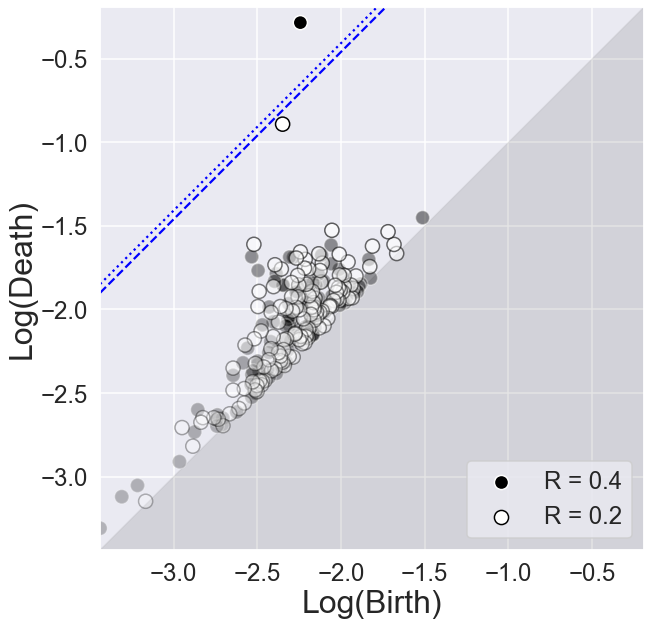

In [3]:
RA = 0.4
RB = 0.2

# load files - these are stored points
# because we use Julia to show the
# corresponding cycles below.
# ---------------------------------
P = np.loadtxt(f'{ROOT}annulus.csv')
P1 = np.loadtxt(f'{ROOT}annulus1.csv')

# compute persistence diagrams
p,i,b,d=makePDFull(P,1)
p1,i1,b1,d1=makePDFull(P1,1)
print(test(process(p))[1][0])
print(test(process(p1))[1][0])

#plot persistence diagram
plt.figure(figsize=(10,10))
ax = plt.axes()
TwoPDplotLineLog(b,d,b1,d1,f'R = {RA}',f'R = {RB}',0.05,ax)
plt.savefig('annulus_PD.pdf', dpi=300,bbox_inches = "tight",pad_inches=0.1)


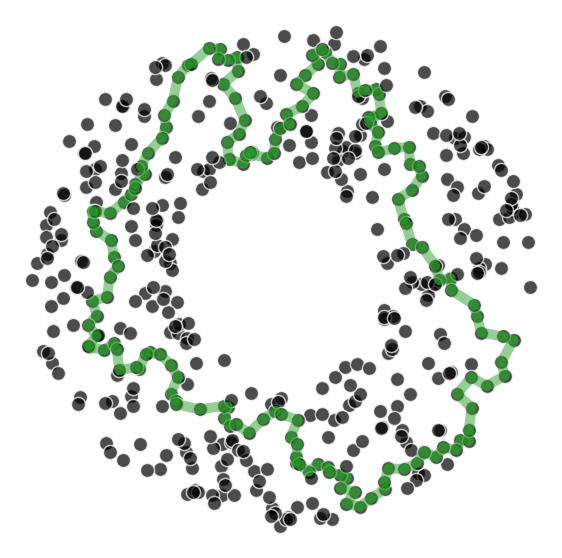

In [4]:
# Cycle plotting
# We ran the script getcycle.jl with Eirene to get the most
# persistent cycle (in terms of the ratio of birth to death)
# see getcycle.jl 
# ----------------
# first point cloud instance
# ----------------
# read in cycle
E = np.loadtxt(f'{ROOT}annulus_cycle.csv',delimiter=',').astype(int)-1
E = E.transpose()

# plot
plt.figure(figsize=(10,10))
ax = plt.axes()
plt.scatter(P[:,0],P[:,1],facecolor='black', edgecolor='white', s=200, alpha=0.7)
ax.plot([P[E[:,0],0],P[E[:,1],0]],[P[E[:,0],1],P[E[:,1],1]],c='tab:green',linewidth=10,alpha=0.5)
ax.set_aspect('equal')
ax.axis('off')
plt.savefig('annulus_sig_cycle.pdf', dpi=300,bbox_inches = "tight",pad_inches=0.1)


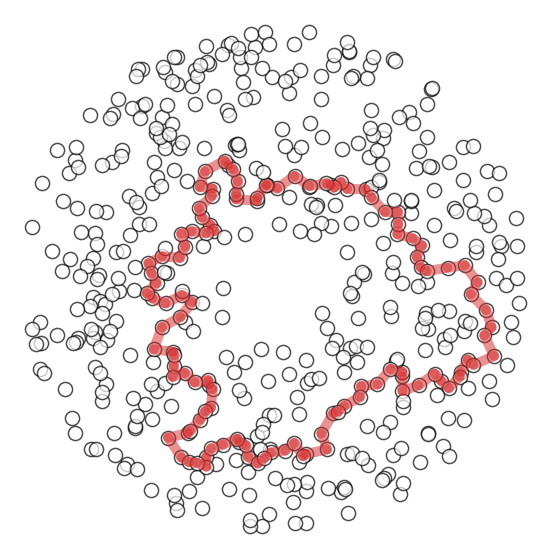

In [5]:
# Cycle plotting
# We ran the script getcycle.jl with Eirene to get the most
# persistent cycle (in terms of the ratio of birth to death)
# see getcycle.jl 
# ----------------
# second point cloud instance
# ----------------
# read in cycle
E = np.loadtxt(f'{ROOT}annulus1_cycle.csv',delimiter=',').astype(int)-1
E = E.transpose()

# plot
plt.figure(figsize=(10,10))
ax = plt.axes()
plt.scatter(P1[:,0],P1[:,1], marker='o', facecolor='white', edgecolor='black', s=200, alpha=0.7)
ax.plot([P1[E[:,0],0],P1[E[:,1],0]],[P1[E[:,0],1],P1[E[:,1],1]],c='tab:red',linewidth=10,alpha=0.5)
ax.set_aspect('equal')
ax.axis('off')
plt.savefig('annulus_nonsig_cycle.pdf', dpi=300,bbox_inches = "tight",pad_inches=0.1)



# Figure 8

[0.00046816 0.01222752]
[0.00140562 1.        ]
B: 1.6958998056870178
M: 99
B: 1.6579027328916918
M: 99


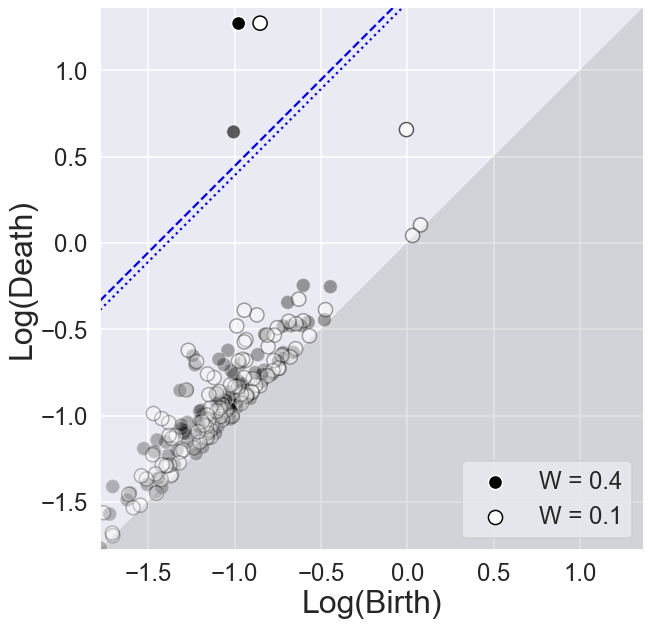

In [6]:
# this parameter controls the width of the neck
RA = 0.4
RB = 0.1


# load files - these are stored points
# because we use Julia to show the
# corresponding cycles below.
# ---------------------------------
P1 = np.loadtxt(f'{ROOT}fig8_nonsig.csv')
P = np.loadtxt(f'{ROOT}fig8_sig.csv')

# compute persistence diagrams
# ---------------------------------
p,i,b,d=makePDFull(P,4)
p1,i1,b1,d1=makePDFull(P1,4)
print(test(process(p))[1][:2])
print(test(process(p1))[1][:2])

#plot persistence diagram
# ---------------------------------
plt.figure(figsize=(10,10))
ax = plt.axes()
TwoPDplotLineLog(b,d,b1,d1,f'W = {RA}',f'W = {RB}',0.05,ax)
plt.savefig('fig8_PD.pdf', dpi=300,bbox_inches = "tight",pad_inches=0.1)


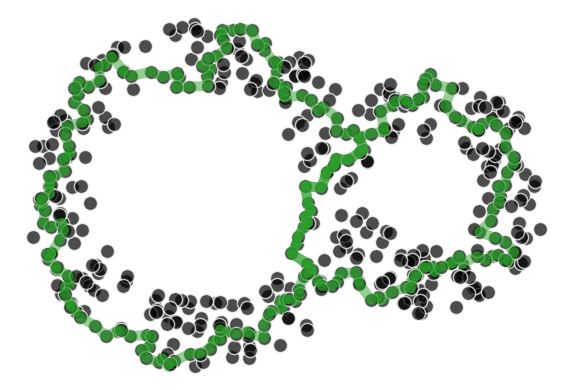

In [7]:
# Cycle plotting
# We ran the script getcycle.jl with Eirene to get the most
# persistent cycle (in terms of the ratio of birth to death)
# see getcycle.jl 
# ----------------
# first point cloud instance
# ----------------
plt.figure(figsize=(10,10))
ax = plt.axes()
plt.scatter(P[:,0],P[:,1],facecolor='black', edgecolor='white', s=200, alpha=0.7)

# both cycles are significant
E = np.loadtxt(f'{ROOT}fig8_sig_cycle2.csv',delimiter=',').astype(int)-1
E = E.transpose()
ax.plot([P[E[:,0],0],P[E[:,1],0]],[P[E[:,0],1],P[E[:,1],1]],c='tab:green',linewidth=10,alpha=0.5)

E = np.loadtxt(f'{ROOT}fig8_sig_cycle1.csv',delimiter=',').astype(int)-1
E = E.transpose()
ax.plot([P[E[:,0],0],P[E[:,1],0]],[P[E[:,0],1],P[E[:,1],1]],c='tab:green',linewidth=10,alpha=0.5)

ax.set_aspect('equal')
ax.axis('off')
plt.savefig('fig8_sig_cycles.pdf', dpi=300,bbox_inches = "tight",pad_inches=0.1)


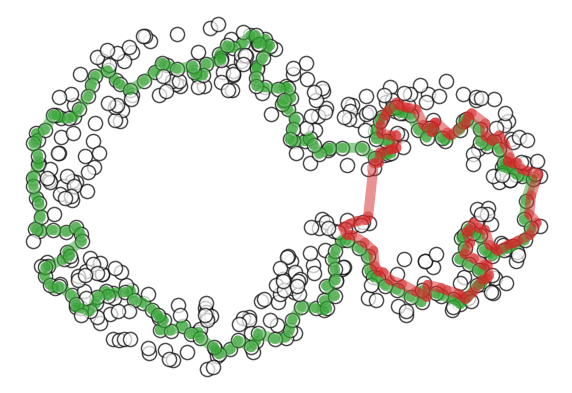

In [8]:
# Cycle plotting
# We ran the script getcycle.jl with Eirene to get the most
# persistent cycle (in terms of the ratio of birth to death)
# see getcycle.jl 
# ----------------
# second point cloud instance
# ----------------

plt.figure(figsize=(10,10))
ax = plt.axes()
plt.scatter(P1[:,0],P1[:,1], marker='o', facecolor='white', edgecolor='black', s=200, alpha=0.7)

# one significant and one not significant
E = np.loadtxt(f'{ROOT}fig8_nonsig_cycle1.csv',delimiter=',').astype(int)-1
E = E.transpose()
ax.plot([P1[E[:,0],0],P1[E[:,1],0]],[P1[E[:,0],1],P1[E[:,1],1]],c='tab:green',linewidth=10,alpha=0.5)
E = np.loadtxt(f'{ROOT}fig8_nonsig_cycle2.csv',delimiter=',').astype(int)-1
E = E.transpose()
ax.plot(np.array([P1[E[:,0],0],P1[E[:,1],0]])+0.1,np.array([P1[E[:,0],1],P1[E[:,1],1]])+0.1,c='tab:red',linewidth=10,alpha=0.5)

ax.set_aspect('equal')
ax.axis('off')
plt.savefig('fig8_nonsig_cycles.pdf', dpi=300,bbox_inches = "tight",pad_inches=0.1)


# Annulus with Cut
#### Fixed Radius with a slab removed

[0.02814153 1.        ]
[0.15547252 1.        ]
B: 1.5772499013180017
M: 102
B: 1.7033064839687952
M: 110


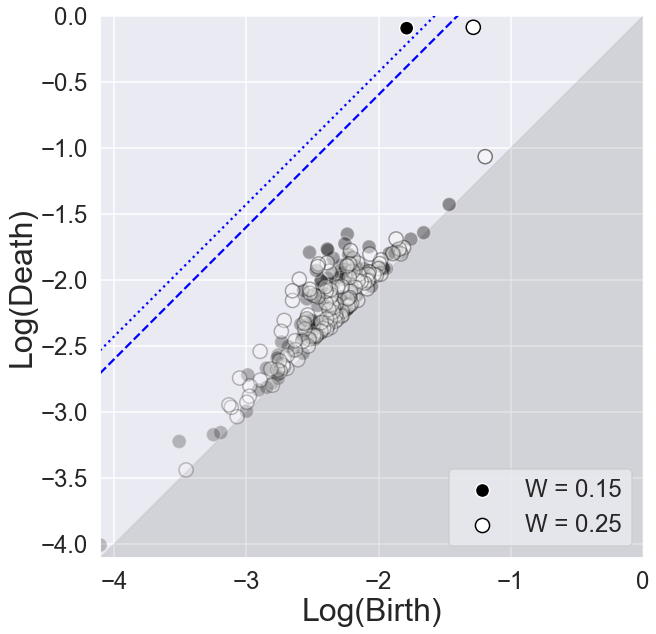

In [9]:
# these are the parameters
# for the cut width
RA = 0.15
RB = 0.25

# load files - these are stored points
# because we use Julia to show the
# corresponding cycles below.
# ---------------------------------
P = np.loadtxt(f'{ROOT}cut.csv')
P1 = np.loadtxt(f'{ROOT}cut1.csv')

# compute persistence diagrams
# ---------------------------------
p,i,b,d=makePDFull(P,1)
p1,i1,b1,d1=makePDFull(P1,1)
print(test(process(p))[1][:2])
print(test(process(p1))[1][:2])

# plot persistence diagrams
# ---------------------------------
plt.figure(figsize=(10,10))
ax = plt.axes()
TwoPDplotLineLog(b,d,b1,d1,f'W = {RA}',f'W = {RB}',0.05,ax)
plt.savefig('annuluscut_PD.pdf', dpi=300,bbox_inches = "tight",pad_inches=0.1)


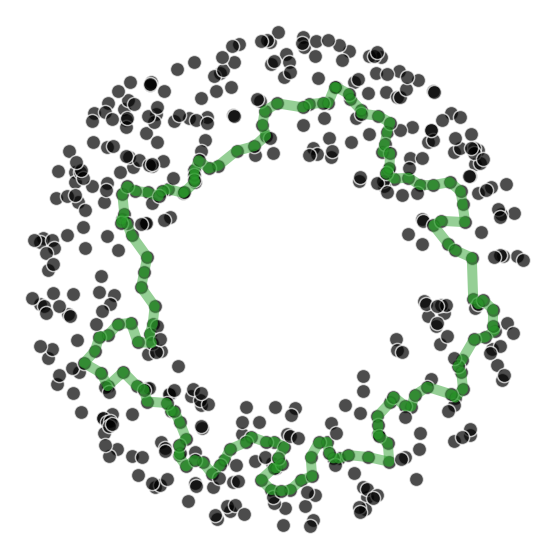

In [10]:
# Cycle plotting
# We ran the script getcycle.jl with Eirene to get the most
# persistent cycle (in terms of the ratio of birth to death)
# see getcycle.jl 
# ----------------
# first point cloud instance
# ----------------
plt.figure(figsize=(10,10))
ax = plt.axes()
plt.scatter(P[:,0],P[:,1],facecolor='black', edgecolor='white', s=200, alpha=0.7)

E = np.loadtxt(f'{ROOT}cut_cycle.csv',delimiter=',').astype(int)-1
E = E.transpose()
ax.plot([P[E[:,0],0],P[E[:,1],0]],[P[E[:,0],1],P[E[:,1],1]],c='tab:green',linewidth=10,alpha=0.5)

ax.set_aspect('equal')
ax.axis('off')
plt.savefig('annuluscut_sig_cycle.pdf', dpi=300,bbox_inches = "tight",pad_inches=0.1)


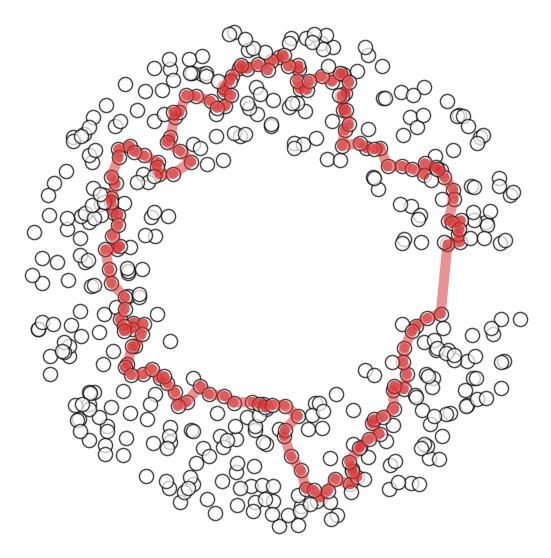

In [11]:
# Cycle plotting
# We ran the script getcycle.jl with Eirene to get the most
# persistent cycle (in terms of the ratio of birth to death)
# see getcycle.jl 
# ----------------
# second point cloud instance
# ----------------

plt.figure(figsize=(10,10))
ax = plt.axes()
plt.scatter(P1[:,0],P1[:,1], marker='o', facecolor='white', edgecolor='black', s=200, alpha=0.7)

E = np.loadtxt(f'{ROOT}cut1_cycle.csv',delimiter=',').astype(int)-1
E = E.transpose()
ax.plot([P1[E[:,0],0],P1[E[:,1],0]],[P1[E[:,0],1],P1[E[:,1],1]],c='tab:red',linewidth=10,alpha=0.5)

ax.set_aspect('equal')
ax.axis('off')
plt.savefig('annuluscut_nonsig_cycle.pdf', dpi=300,bbox_inches = "tight",pad_inches=0.1)


# Generic example
#### This generates Figure 1 in the paper

In [36]:
# For computing Alpha - we use gudhi and diode
import diode as dd
import gudhi as gd

# the following code
# only works in 2d and 3d
# returns the persistence diagram
# for the alpha complex.
def persistenceAlpha(P):
    C = dd.fill_alpha_shapes(P)
    D = 3
    st = gd.SimplexTree()
    for s,f in C:
        st.insert(s,filtration=f)

    diag = st.persistence()

    birth_all =  [ [] for _ in range(D) ]
    death_all = [ [] for _ in range(D) ]
    inf_all = [ [] for _ in range(D) ]
    for d,p in diag:
        if (p[1]==np.inf):
            inf_all[d].append(p[0])
        else:
            birth_all[d].append(p[0])
            death_all[d].append(p[1])
    
    return birth_all,death_all,inf_all


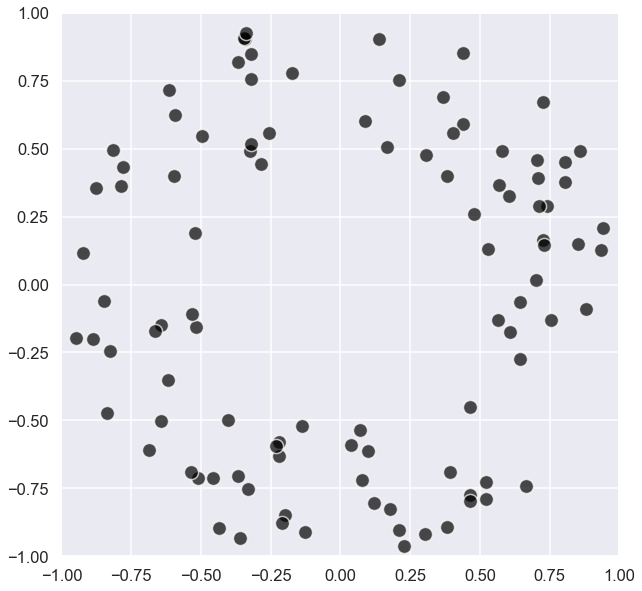

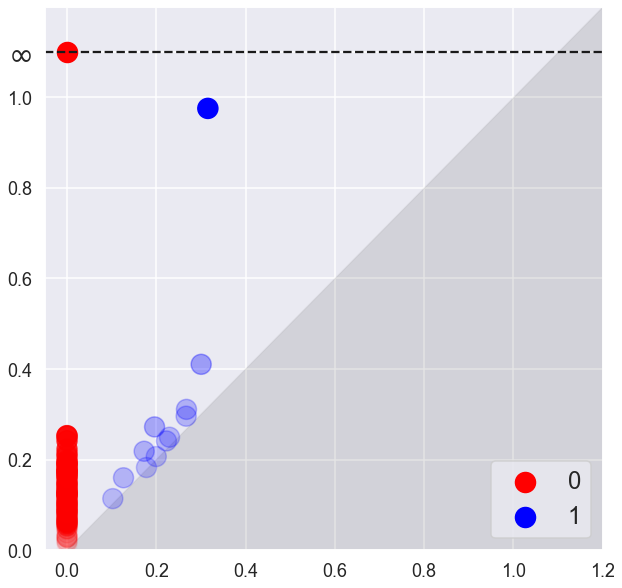

In [37]:
# generate the figure
# with rips - not in the paper
#--------------------

# generate points and plot them
#--------------------
P = ann_cut(2,100)
plt.figure(figsize=(10,10))
ax = plt.axes()
plt.scatter(P[:,0],P[:,1],facecolor='black', edgecolor='white', s=200, alpha=0.7)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
plt.savefig('ex_pts.pdf', dpi=300,bbox_inches = "tight",pad_inches=0.1)


#--------------------

plt.figure(figsize=(10,10))
ax = plt.axes()

# Compute diagram
#--------------------
b,d,i=persistenceRipser(P,1)


# Visual fine-tuning
#--------------------

mn = 0
mx = 1.2
ax.fill([mn,mx,mx],[mn,mn,mx],facecolor='black',edgecolor='gray',alpha=0.1)
ax.plot([-0.05,1.2],[1.1,1.1],'k--')

ax.scatter(b[0],d[0],facecolor='red', edgecolor='red',s=400, label='0',alpha=0.799*(np.array(d[0])/np.max(d[0])))
s = (np.array(d[1])-np.array(b[1]))            
ax.scatter(b[1],d[1],facecolor='blue', edgecolor='blue',s=400, label='1',alpha=0.799*s/np.max(s)+0.2)

ax.scatter(i[0],1.1,facecolor='red', edgecolor='red',s=400,alpha=1)

ax.set_xlim([-0.05,1.2])
ax.set_ylim([0.01,1.2])

leg=ax.legend(loc='lower right',fontsize=24)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.draw() 
plt.yticks([0. , 0.2, 0.4, 0.6, 0.8, 1. ,1.1, 1.2],\
           ['0.0', '0.2', '0.4' ,'0.6','0.8','1.0','$\infty$',''],fontsize=18)
ax.get_yticklabels()[-2].set_fontsize(30)
for i in ax.get_xticklabels():
    i.set_fontsize(18)
plt.savefig('ex_rips.pdf', dpi=300,bbox_inches = "tight",pad_inches=0.1)

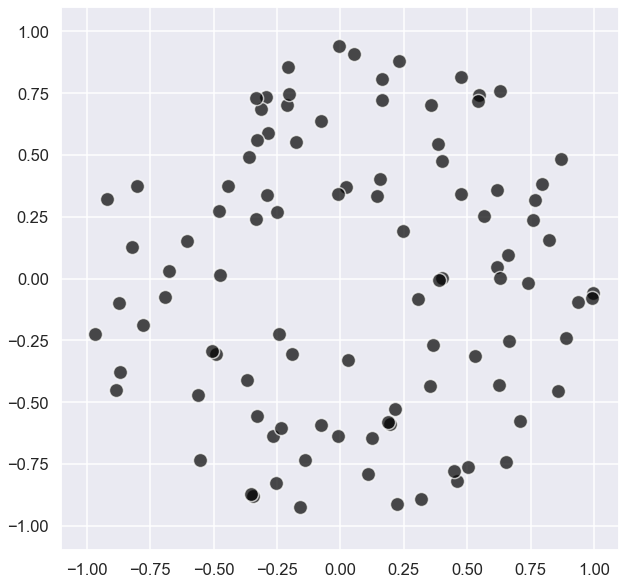

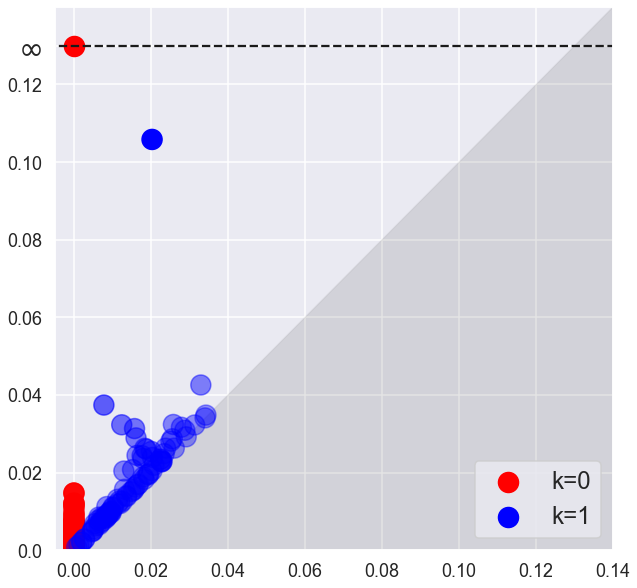

In [38]:
# generate the figure
# with alpha
#--------------------


# generate points and plot them
#--------------------
P = ann_cut(2,100,R1=0.3)
plt.figure(figsize=(10,10))
ax = plt.axes()
plt.scatter(P[:,0],P[:,1],facecolor='black', edgecolor='white', s=200, alpha=0.7)
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
plt.savefig('ex_pts1.pdf', dpi=300,bbox_inches = "tight",pad_inches=0.1)


# Plot persistence diagram
#--------------------
plt.figure(figsize=(10,10))
ax = plt.axes()

# compute diagram
b,d,i = persistenceAlpha(P)

# visual fine tuning
mn = 0
mx = 0.14
e=0.4

ax.fill([mn,mx,mx],[mn,mn,mx],facecolor='black',edgecolor='gray',alpha=0.1)
ax.plot([-0.01,mx],[0.13,0.13],'k--')

ax.scatter(b[0],d[0],facecolor='red', edgecolor='red',s=400, label='k=0',alpha=(1-e-0.001)*(np.array(d[0])/np.max(d[0])+e))

s = (np.array(d[1])-np.array(b[1]))            
ax.scatter(b[1],d[1],facecolor='blue', edgecolor='blue',s=400, label='k=1',alpha=(1-e-0.001)*s/np.max(s)+e)

ax.scatter(i[0],1.1,facecolor='red', edgecolor='red',s=400,alpha=1)

ax.scatter(i[0],0.13,facecolor='red', edgecolor='red',s=400,alpha=1)

ax.set_xlim([-0.005,mx])
ax.set_ylim([0.0,mx])

leg=ax.legend(loc='lower right',fontsize=24)
for lh in leg.legendHandles: 
     lh.set_alpha(1)
plt.draw() 
plt.yticks([0.0 , 0.02, 0.04, 0.06, 0.08, 0.1 ,.12, .13],\
            ['0.0', '0.02', '0.04' ,'0.06','0.08','0.10','0.12','$\infty$'],fontsize=18)
ax.get_yticklabels()[-1].set_fontsize(30)
for i in ax.get_xticklabels():
     i.set_fontsize(18)
plt.savefig('ex_alpha.pdf', dpi=300,bbox_inches = "tight",pad_inches=0.1)


### Rips and Cech - Appendix

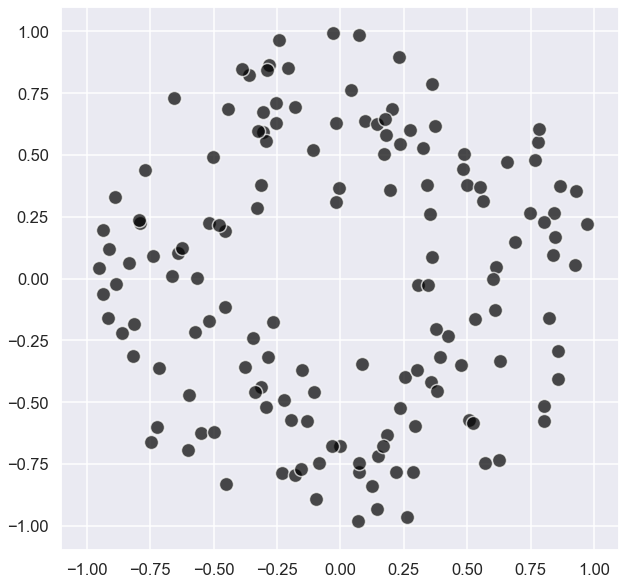

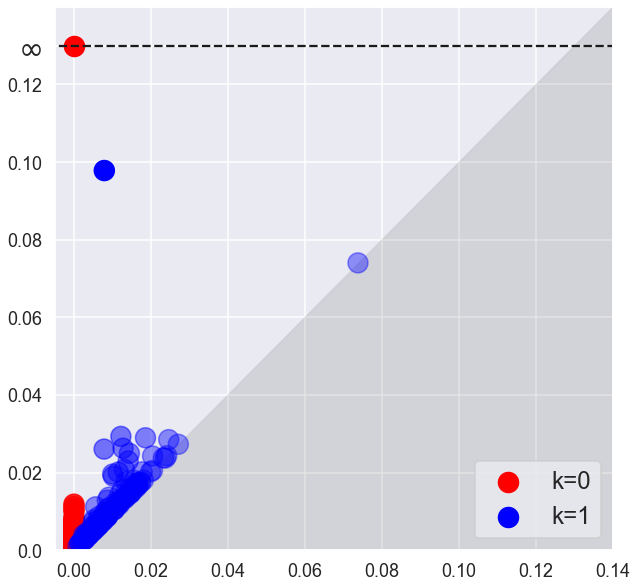

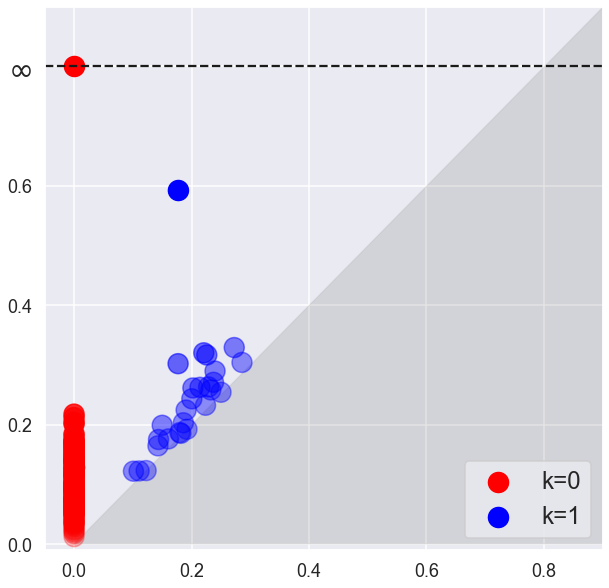

In [64]:
# generate the figure
# with alpha
#--------------------


# generate points and plot them
#--------------------
P = ann_cut(2,150,R1=0.3)
plt.figure(figsize=(10,10))
ax = plt.axes()
plt.scatter(P[:,0],P[:,1],facecolor='black', edgecolor='white', s=200, alpha=0.7)
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
plt.savefig('ex_pts_appendix.pdf', dpi=300,bbox_inches = "tight",pad_inches=0.1)


# Plot persistence diagram - Cech
#--------------------
plt.figure(figsize=(10,10))
ax = plt.axes()

# compute diagram -  Cech
b,d,i = persistenceAlpha(P)


# visual fine tuning
mn = 0
mx = 0.14
e=0.4

ax.fill([mn,mx,mx],[mn,mn,mx],facecolor='black',edgecolor='gray',alpha=0.1)
ax.plot([-0.01,mx],[0.13,0.13],'k--')

ax.scatter(b[0],d[0],facecolor='red', edgecolor='red',s=400, label='k=0',alpha=(1-e-0.001)*(np.array(d[0])/np.max(d[0])+e))

s = (np.array(d[1])-np.array(b[1]))            
ax.scatter(b[1],d[1],facecolor='blue', edgecolor='blue',s=400, label='k=1',alpha=(1-e-0.001)*s/np.max(s)+e)

ax.scatter(i[0],1.1,facecolor='red', edgecolor='red',s=400,alpha=1)

ax.scatter(i[0],0.13,facecolor='red', edgecolor='red',s=400,alpha=1)

ax.set_xlim([-0.005,mx])
ax.set_ylim([0.0,mx])

leg=ax.legend(loc='lower right',fontsize=24)
for lh in leg.legendHandles: 
     lh.set_alpha(1)
plt.draw() 
plt.yticks([0.0 , 0.02, 0.04, 0.06, 0.08, 0.1 ,.12, .13],\
           ['0.0', '0.02', '0.04' ,'0.06','0.08','0.10','0.12','$\infty$'],fontsize=18)
ax.get_yticklabels()[-1].set_fontsize(30)
for i in ax.get_xticklabels():
     i.set_fontsize(18)
plt.savefig('ex_alpha_appendix.pdf', dpi=300,bbox_inches = "tight",pad_inches=0.1)


# Plot persistence diagram - Rips
#--------------------
plt.figure(figsize=(10,10))
ax = plt.axes()

# compute diagram -  Rips
b,d,i = persistenceRipser(P,1)

# visual fine tuning
mn = 0
mx = 0.9
mxinf = 0.8 
e = 0.4

ax.fill([mn,mx,mx],[mn,mn,mx],facecolor='black',edgecolor='gray',alpha=0.1)
ax.plot([-0.05,mx],[mxinf,mxinf],'k--')

ax.scatter(b[0],d[0],facecolor='red', edgecolor='red',s=400, label='k=0',alpha=(1-e-0.001)*(np.array(d[0])/np.max(d[0])+e))

s = (np.array(d[1])-np.array(b[1]))            
ax.scatter(b[1],d[1],facecolor='blue', edgecolor='blue',s=400, label='k=1',alpha=(1-e-0.001)*s/np.max(s)+e)

ax.scatter(i[0],mxinf,facecolor='red', edgecolor='red',s=400,alpha=1)

ax.scatter(i[0],0.13,facecolor='red', edgecolor='red',s=400,alpha=1)

ax.set_xlim([-0.05,mx])
ax.set_ylim([-0.01,mx])

leg=ax.legend(loc='lower right',fontsize=24)
for lh in leg.legendHandles: 
     lh.set_alpha(1)
plt.draw() 
plt.yticks([0.0 , 0.2, 0.4, 0.6, 0.8],\
            ['0.0', '0.2', '0.4' ,'0.6','$\infty$'],fontsize=18)
ax.get_yticklabels()[-1].set_fontsize(30)
for i in ax.get_xticklabels():
     i.set_fontsize(18)
plt.savefig('ex_rips_appendix.pdf', dpi=300,bbox_inches = "tight",pad_inches=0.1)
